<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#COCO-examples" data-toc-modified-id="COCO-examples-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>COCO examples</a></span><ul class="toc-item"><li><span><a href="#Basic-structure" data-toc-modified-id="Basic-structure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Basic structure</a></span></li><li><span><a href="#BBoxLabeler" data-toc-modified-id="BBoxLabeler-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>BBoxLabeler</a></span></li></ul></li></ul></div>

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
train_json   = 'annotations/instances_train2017.json'
valid_json   = 'annotations/instances_val2017.json'
train_im_dir = 'train2017'
valid_im_dir = 'val2017'

In [ ]:
### Get files and annos ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]


### Get largest anno ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)
# get_xyz helpers (used in following sections)
files2lbl  = {f:l for f,l in zip(files,largest_lbl)}
files2bbox = {f:b for f,b in zip(files,largest_bbox)}
def get_lbl(f):  return files2lbl[f]
def get_bbox(f): return files2bbox[f]


### Get singles ###
# identify singles
lbls_per_im = L(len(l) for l in lbls)
tuples = L(zip(files, largest_lbl, largest_bbox))
singles = tuples[lbls_per_im.map(lambda n:n==1)]
singles_tp = transpose(singles)
# identify lbls with at least 500 singles
lbl2paths = {l:[p for p in singles_tp[0] if get_lbl(p) == l] 
             for l in set(singles_tp[1])}
lbl_subset=[]
for lbl in lbl2paths:
    l = len(lbl2paths[lbl])
    if l > 500: lbl_subset += [lbl]
# create subset of ims in lbl_subset
subset = L(s for s in singles if s[1] in lbl_subset)
files_subset = L(i[0] for i in subset)

In [ ]:
subset[0:3]

(#3) [(Path('/home/rory/data/coco2017/train2017/000000060760.jpg'), 'toilet', [240.45, 412.36, 375.0, 494.38]),(Path('/home/rory/data/coco2017/train2017/000000360772.jpg'), 'toilet', [117.93, 271.58, 407.01, 634.01]),(Path('/home/rory/data/coco2017/train2017/000000191381.jpg'), 'toilet', [102.7, 0.0, 475.68, 387.57])]

In [ ]:
### Datasets ###

# transforms
dss_tfms = [[PILImage.create], [get_bbox, tensor]]

# create dss
splits = RandomSplitter(.15)(files_subset)
dss = Datasets(files_subset, tfms=dss_tfms, splits=splits)

dss.train[0]

(PILImage mode=RGB size=500x334,
 tensor([292.4700,  55.0600, 331.8000, 119.0300]))

In [ ]:
### DataLoaders ###
cpu_tfms = [Resize(im_size, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)

In [ ]:
xb,yb = dls.get_batch()
yb[0]

AttributeError: get_batch

epoch,train_loss,valid_loss,accuracy,time
0,0.480485,0.101918,0.966423,00:11
1,0.187428,0.080255,0.981022,00:11


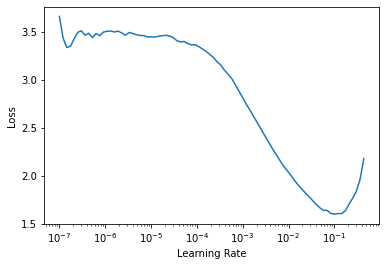

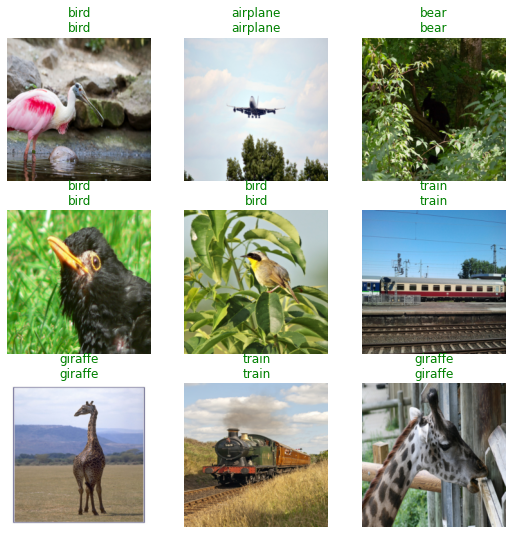

In [ ]:
### Model & Train ###
learn = cnn_learner(dls, resnet34, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
learn.fit_one_cycle(2, lr=lr_min) # train t=32s; 128px→.966; 224px→.981
learn.show_results()

## COCO examples

### Basic structure

https://docs.fast.ai/vision.core#TensorBBox

Bounding boxes are expected to come as tuple with an array/tensor of shape (n,4) or as a list of lists with four elements and a list of corresponding labels.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn, bbox = coco/'train'/images[idx],lbl_bbox[idx]
coco_fn

Path('/home/rory/.fastai/data/coco_tiny/train/000000153607.jpg')

In [ ]:
bbox # tuple of list-of-lists, list

([[6.33, 34.52, 73.06, 107.28999999999999],
  [76.8, 48.61, 128.0, 122.25],
  [95.42, 4.32, 123.42, 31.93]],
 ['vase', 'vase', 'vase'])

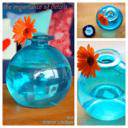

In [ ]:
timg = Transform(PILImage.create)
coco_img = timg(coco_fn)
coco_img

In [ ]:
tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
tbbox

(#2) [TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]),['vase', 'vase', 'vase']]

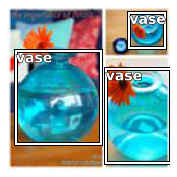

In [ ]:
ctx = coco_img.show(figsize=(3,3))
tbbox.show(ctx=ctx);

### BBoxLabeler

https://docs.fast.ai/vision.core#BBoxLabeler

Delegates (`__call__`,`decode`,`setup`) to (`encodes`,`decodes`,`setups`) if split_idx matches

In [ ]:
def _coco_bb(x):  return TensorBBox.create(bbox[0])
def _coco_lbl(x): return bbox[1]

In [ ]:
coco_tds = Datasets([coco_fn],
                    [PILImage.create,
                        [_coco_bb],
                        [_coco_lbl, MultiCategorize(add_na=True)]
                    ], n_inp=1)

coco_tds

(#1) [(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1]))]

In [ ]:
coco_tdl = TfmdDL(coco_tds, bs=1,
                  after_item=[BBoxLabeler(), PointScaler(), ToTensor()])


coco_tdl.tfms

(#3) [Pipeline: PILBase.create,Pipeline: _coco_bb,Pipeline: _coco_lbl -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}]

In [ ]:
x,y,z = coco_tdl.one_batch()
x,y,z

(TensorImage([[[[255, 249, 255,  ..., 248, 233, 221],
           [255, 255, 251,  ..., 255, 244, 234],
           [252, 249, 207,  ..., 251, 255, 252],
           ...,
           [241, 251, 244,  ..., 217, 255, 255],
           [226, 237, 255,  ..., 254, 255, 255],
           [213, 221, 242,  ..., 254, 255, 255]],
 
          [[254, 243, 255,  ..., 255, 255, 255],
           [252, 254, 255,  ..., 251, 255, 255],
           [253, 255, 223,  ..., 232, 252, 253],
           ...,
           [255, 250, 217,  ..., 232, 250, 246],
           [255, 255, 255,  ..., 255, 253, 251],
           [255, 255, 255,  ..., 248, 250, 254]],
 
          [[236, 231, 251,  ..., 255, 255, 255],
           [242, 250, 255,  ..., 252, 255, 255],
           [255, 255, 239,  ..., 218, 255, 255],
           ...,
           [255, 246, 196,  ..., 229, 251, 249],
           [255, 255, 253,  ..., 255, 251, 248],
           [255, 255, 255,  ..., 248, 246, 248]]]], dtype=torch.uint8),
 TensorBBox([[[-0.9011, -0.4606,  0.

In [ ]:
a,b,c = coco_tdl.decode_batch((x,y,z))[0]
a,b,c

(TensorImage([[[255, 249, 255,  ..., 248, 233, 221],
          [255, 255, 251,  ..., 255, 244, 234],
          [252, 249, 207,  ..., 251, 255, 252],
          ...,
          [241, 251, 244,  ..., 217, 255, 255],
          [226, 237, 255,  ..., 254, 255, 255],
          [213, 221, 242,  ..., 254, 255, 255]],
 
         [[254, 243, 255,  ..., 255, 255, 255],
          [252, 254, 255,  ..., 251, 255, 255],
          [253, 255, 223,  ..., 232, 252, 253],
          ...,
          [255, 250, 217,  ..., 232, 250, 246],
          [255, 255, 255,  ..., 255, 253, 251],
          [255, 255, 255,  ..., 248, 250, 254]],
 
         [[236, 231, 251,  ..., 255, 255, 255],
          [242, 250, 255,  ..., 252, 255, 255],
          [255, 255, 239,  ..., 218, 255, 255],
          ...,
          [255, 246, 196,  ..., 229, 251, 249],
          [255, 255, 253,  ..., 255, 251, 248],
          [255, 255, 255,  ..., 248, 246, 248]]], dtype=torch.uint8),
 TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
   

In [ ]:
# encoded types inside the tfmdl
test_eq(type(x), TensorImage)
test_eq(type(y), TensorBBox)
test_eq(type(z), TensorMultiCategory)

# decoded types
test_eq(type(a), TensorImage)
test_eq(type(b), TensorBBox)  # notice that in the above. tensorbbox appears here...
test_eq(type(c), LabeledBBox) # ... and here.